In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Cell 1 (Revised V2): Force Clean Install of Terratorch, then Main Package + Debug
import os
import sys
from pathlib import Path

print(f"Initial CWD: {os.getcwd()}")
# Ensure we are in /kaggle/working/ for correct relative path management if any further commands need it
if os.getcwd() != "/kaggle/working":
    os.chdir("/kaggle/working")
    print(f"Changed CWD to: {os.getcwd()}")

# --- Step 1: Uninstall existing versions to ensure a clean slate ---
print("\n--- Uninstalling existing granite_geo_flood and terratorch (if any) ---")
!pip uninstall granite_geo_flood -y
!pip uninstall terratorch -y
print("--- Uninstallation complete ---")

# --- Step 2: Clone the 'geospatial' repository if it doesn't exist ---
geospatial_repo_path = Path("/kaggle/working/geospatial")
if not geospatial_repo_path.exists():
    print(f"\n--- Cloning repository '{geospatial_repo_path.name}' ---")
    # Clone into /kaggle/working/geospatial
    !git clone https://github.com/ibm-granite/geospatial.git {str(geospatial_repo_path)}
else:
    print(f"\n--- Repository '{geospatial_repo_path.name}' already exists at {geospatial_repo_path} ---")

# --- Step 3: Install 'terratorch' directly from the specific git commit ---
# This is the commit pinned as a dependency by granite_geo_flood
terratorch_commit = "6d97521"
print(f"\n--- Installing 'terratorch' directly from git commit {terratorch_commit} ---")
# This will be a standard installation, not editable.
# Watch the output of this command carefully for any errors during terratorch build/install.
!pip install git+https://github.com/IBM/terratorch.git@{terratorch_commit}

# --- Step 4: Install the 'uki-flooddetection' package in editable mode ---
# Pip should now see that the terratorch dependency is already met by the version we just installed.
package_to_install_path = geospatial_repo_path / "uki-flooddetection"
if package_to_install_path.exists() and (package_to_install_path / "pyproject.toml").exists():
    print(f"\n--- Installing 'uki-flooddetection' in editable mode from: {package_to_install_path} ---")
    !pip install -e {str(package_to_install_path)}[colab]
else:
    print(f"ERROR: 'uki-flooddetection' package directory {package_to_install_path} or its pyproject.toml not found!")
    print("Please check the git clone step for 'geospatial' and the path construction.")

# --- Step 5: Debug Terratorch Import Immediately After All Installs ---
print("\n--- Running Post-Install Debug ---")
print("Attempting to import terratorch and SemanticSegmentationTask...")
IMPORTED_SEMANTIC_SEGMENTATION_TASK_CLASS = None # Variable to hold the class if successfully imported

try:
    import terratorch
    print(f"Successfully imported 'terratorch'.")
    print(f"  Version (if available): {terratorch.__version__ if hasattr(terratorch, '__version__') else 'N/A'}")
    print(f"  Path: {terratorch.__path__}")

    import terratorch.models
    print(f"Successfully imported 'terratorch.models'.")
    print(f"  Path: {terratorch.models.__path__}")
    # print(f"  Contents of 'terratorch.models': {dir(terratorch.models)}") # Can be very verbose

    # Attempt 1: Direct import from the submodule (terratorch.models.segmentation_tasks)
    print("\nAttempt 1: Importing from 'terratorch.models.segmentation_tasks.SemanticSegmentationTask'...")
    try:
        from terratorch.models.segmentation_tasks import SemanticSegmentationTask
        print("  SUCCESS (Attempt 1): Imported 'SemanticSegmentationTask' from 'terratorch.models.segmentation_tasks'.")
        IMPORTED_SEMANTIC_SEGMENTATION_TASK_CLASS = SemanticSegmentationTask
    except ImportError as e1:
        print(f"  FAILURE (Attempt 1): Could not import from 'terratorch.models.segmentation_tasks': {e1}")
        # Attempt 2: Import from terratorch.models (as per original config's class_path)
        print("\nAttempt 2: Importing from 'terratorch.models.SemanticSegmentationTask'...")
        try:
            from terratorch.models import SemanticSegmentationTask
            print("  SUCCESS (Attempt 2): Imported 'SemanticSegmentationTask' from 'terratorch.models'.")
            IMPORTED_SEMANTIC_SEGMENTATION_TASK_CLASS = SemanticSegmentationTask
        except ImportError as e2:
            print(f"  FAILURE (Attempt 2): Could not import from 'terratorch.models': {e2}")
            print("  CRITICAL: 'SemanticSegmentationTask' could not be imported through any known method.")

    if IMPORTED_SEMANTIC_SEGMENTATION_TASK_CLASS:
        print("\n*** SemanticSegmentationTask appears to be successfully imported and ready for use in Cell H2! ***")
    else:
        print("\n*** SemanticSegmentationTask could NOT be imported. Cell H2 will likely fail. ***")
        print("Please review the 'pip install git+https://github.com/IBM/terratorch.git...' log above for any errors during its specific installation.")
        # Provide more detailed debug if both attempts failed
        print("\nFurther Debug Info:")
        try:
            import terratorch.models
            print(f"  Contents of 'terratorch.models' module: {[name for name in dir(terratorch.models) if not name.startswith('_')]}")
            # Check if segmentation_tasks submodule exists
            if hasattr(terratorch.models, 'segmentation_tasks'):
                 import terratorch.models.segmentation_tasks
                 print(f"  Successfully imported 'terratorch.models.segmentation_tasks'.")
                 print(f"  Contents of 'segmentation_tasks': {[name for name in dir(terratorch.models.segmentation_tasks) if not name.startswith('_')]}")
            else:
                print("  Submodule 'terratorch.models.segmentation_tasks' not found.")
        except Exception as debug_e:
            print(f"  Error during detailed debug: {debug_e}")


except ImportError as e_outer:
    print(f"\nOuter ImportError during debug (likely 'import terratorch' failed): {e_outer}")
    print("This suggests a fundamental issue with 'terratorch' package installation or availability.")
except Exception as e_general:
    print(f"\nAn unexpected error occurred during the entire debug process: {e_general}")
    import traceback
    traceback.print_exc()

In [1]:
# Cell A: Define Absolute Project Root and Set CWD
import os
from pathlib import Path

print("Running Cell A: Define Absolute Project Root and Set CWD...")

# This should be the root of the cloned 'uki-flooddetection' project
absolute_project_root = Path("/kaggle/working/geospatial/uki-flooddetection/")

if not absolute_project_root.exists():
    print(f"ERROR: The base project directory {absolute_project_root} does not exist!")
    print("Please ensure you have successfully run Cell 1 to clone the 'geospatial' repository.")
    print("The path should lead to the 'uki-flooddetection' folder inside 'geospatial'.")
else:
    print(f"Confirmed project root: {absolute_project_root}")

    # For script compatibility, try to change CWD to the 'notebooks' directory
    notebooks_dir = absolute_project_root / "notebooks"
    if notebooks_dir.exists():
        try:
            os.chdir(notebooks_dir)
            print(f"Successfully changed CWD to: {Path.cwd()}")
        except Exception as e:
            print(f"Error changing CWD to {notebooks_dir}: {e}")
            print(f"Current CWD remains: {Path.cwd()}")
    else:
        print(f"WARNING: Notebooks directory {notebooks_dir} not found.")
        print(f"The script's internal relative paths might not work as expected.")
        print(f"Current CWD: {Path.cwd()}")

project_root_for_script_logic = Path("../")

Running Cell A: Define Absolute Project Root and Set CWD...
Confirmed project root: /kaggle/working/geospatial/uki-flooddetection
Successfully changed CWD to: /kaggle/working/geospatial/uki-flooddetection/notebooks


In [2]:
# Cell B: Download Configuration File
from pathlib import Path
from huggingface_hub import hf_hub_download
import os

print("\nRunning Cell B: Download Configuration File...")
if 'absolute_project_root' not in locals() or not absolute_project_root.exists():
    print("ERROR: 'absolute_project_root' is not defined or does not exist. Please run Cell A first.")
else:
    hf_repo_name = "ibm-granite/granite-geospatial-uki-flooddetection"
    config_name_original = "config.yaml"
    config_name_renamed = "config_granite_geospatial_uki_flood_detection_v1.yaml"

    config_folder_abs = absolute_project_root / "configs"
    os.makedirs(config_folder_abs, exist_ok=True)
    print(f"Ensured config folder exists: {config_folder_abs}")

    downloaded_config_path_abs = Path(
        hf_hub_download(
            repo_id=hf_repo_name,
            filename=config_name_original,
            local_dir=config_folder_abs,
            local_dir_use_symlinks=False # Good practice for Kaggle
        )
    )
    print(f"Config initially downloaded to: {downloaded_config_path_abs}")

    final_config_path_abs = config_folder_abs / config_name_renamed
    if downloaded_config_path_abs.exists():
        if downloaded_config_path_abs != final_config_path_abs:
            downloaded_config_path_abs.replace(final_config_path_abs)
            print(f"Config file successfully renamed to: {final_config_path_abs}")
        elif final_config_path_abs.exists(): # Already correct
             print(f"Config file already at final path: {final_config_path_abs}")
        if final_config_path_abs.exists():
             print(f"\n>>> Path for manual input (Config File): {str(final_config_path_abs)}")
        else:
            print(f"ERROR: Config file NOT found at expected final path {final_config_path_abs} after potential rename.")
    else:
        print(f"ERROR: Downloaded config file NOT found at {downloaded_config_path_abs} before attempting rename.")


Running Cell B: Download Configuration File...
Ensured config folder exists: /kaggle/working/geospatial/uki-flooddetection/configs


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


config.yaml:   0%|          | 0.00/3.64k [00:00<?, ?B/s]

Config initially downloaded to: /kaggle/working/geospatial/uki-flooddetection/configs/config.yaml
Config file successfully renamed to: /kaggle/working/geospatial/uki-flooddetection/configs/config_granite_geospatial_uki_flood_detection_v1.yaml

>>> Path for manual input (Config File): /kaggle/working/geospatial/uki-flooddetection/configs/config_granite_geospatial_uki_flood_detection_v1.yaml


In [3]:
# Cell C: Download Model Checkpoint
from pathlib import Path
from huggingface_hub import hf_hub_download
import os

print("\nRunning Cell C: Download Model Checkpoint...")
if 'absolute_project_root' not in locals() or not absolute_project_root.exists():
    print("ERROR: 'absolute_project_root' is not defined or does not exist. Please run Cell A first.")
else:
    hf_repo_name = "ibm-granite/granite-geospatial-uki-flooddetection"
    checkpoint_name = "granite_geospatial_uki_flood_detection_v1.ckpt"

    checkpoint_folder_abs = absolute_project_root / "data" / "checkpoints"
    os.makedirs(checkpoint_folder_abs, exist_ok=True)
    print(f"Ensured checkpoint folder exists: {checkpoint_folder_abs}")

    final_checkpoint_path_abs = Path(
        hf_hub_download(
            repo_id=hf_repo_name,
            filename=checkpoint_name,
            local_dir=checkpoint_folder_abs,
            local_dir_use_symlinks=False # Good practice for Kaggle
        )
    )

    if final_checkpoint_path_abs.exists():
        print(f"Checkpoint successfully downloaded to: {final_checkpoint_path_abs}")
        print(f"\n>>> Path for manual input (Checkpoint File): {str(final_checkpoint_path_abs)}")
    else:
        print(f"ERROR: Checkpoint file NOT found at {final_checkpoint_path_abs} after download attempt.")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



Running Cell C: Download Model Checkpoint...
Ensured checkpoint folder exists: /kaggle/working/geospatial/uki-flooddetection/data/checkpoints


(…)e_geospatial_uki_flood_detection_v1.ckpt:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

Checkpoint successfully downloaded to: /kaggle/working/geospatial/uki-flooddetection/data/checkpoints/granite_geospatial_uki_flood_detection_v1.ckpt

>>> Path for manual input (Checkpoint File): /kaggle/working/geospatial/uki-flooddetection/data/checkpoints/granite_geospatial_uki_flood_detection_v1.ckpt


In [4]:
# Cell D: Download and Extract Data
from pathlib import Path
import os

print("\nRunning Cell D: Download and Extract Data...")

if 'absolute_project_root' not in locals() or not absolute_project_root.exists():
    print("ERROR: 'absolute_project_root' is not defined or does not exist. Please run Cell A first.")
else:
    try:
        from granite_geo_flood.utils.helper import download_data
        helper_imported = True
    except ImportError:
        print("ERROR: Could not import 'download_data' from 'granite_geo_flood.utils.helper'.")
        print("Please ensure Cell 1 (pip install) completed successfully and you've restarted the kernel if prompted and re-ran Cell 1.")
        helper_imported = False

    if helper_imported:
        data_download_target_dir_abs = absolute_project_root / "data"
        # This is where the tarball's contents (regions/uki/holdout/images) will be extracted relative to.
        regions_base_extract_dir_abs = data_download_target_dir_abs / "regions"

        os.makedirs(data_download_target_dir_abs, exist_ok=True)
        
        tarball_save_path_abs = data_download_target_dir_abs / "granite-geospatial-uki-flooddetection-dataset-uki.tar.gz"

        print(f"Attempting to download data to: {tarball_save_path_abs}")
        download_data("uki", tarball_save_path_abs) # download_data is from the library

        if tarball_save_path_abs.exists():
            print(f"Data tarball successfully downloaded to: {tarball_save_path_abs}")

            extraction_target_directory_for_tar = regions_base_extract_dir_abs
            os.makedirs(extraction_target_directory_for_tar, exist_ok=True)

            command = f'tar -vxf "{str(tarball_save_path_abs)}" --directory "{str(extraction_target_directory_for_tar)}"'
            print(f"Executing extraction command: {command}")
            exit_code = os.system(command)

            if exit_code == 0:
                print(f"Data successfully extracted into {extraction_target_directory_for_tar} and its subdirectories.")
                # The specific path for input images
                final_input_images_path_abs = extraction_target_directory_for_tar / "uki" / "holdout" / "images"
                if final_input_images_path_abs.exists() and final_input_images_path_abs.is_dir():
                    print(f"\n>>> Path for manual input (Input Data Root): {str(final_input_images_path_abs)}")
                else:
                    print(f"ERROR: Expected input images directory NOT FOUND at {final_input_images_path_abs} after extraction.")
            else:
                print(f"ERROR: Tar extraction command failed with exit code {exit_code}.")
        else:
            print(f"ERROR: Data tarball NOT found at {tarball_save_path_abs} after download attempt.")


Running Cell D: Download and Extract Data...
Attempting to download data to: /kaggle/working/geospatial/uki-flooddetection/data/granite-geospatial-uki-flooddetection-dataset-uki.tar.gz


--2025-05-13 17:13:25--  https://zenodo.org/records/14216851/files/granite-geospatial-uki-flooddetection-dataset-uki.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72649805 (69M) [application/octet-stream]
Saving to: ‘/kaggle/working/geospatial/uki-flooddetection/data/granite-geospatial-uki-flooddetection-dataset-uki.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  176K 6m42s
    50K .......... .......... .......... .......... ..........  0%  455K 4m39s
   100K .......... .......... .......... .......... ..........  0% 76.5M 3m6s
   150K .......... .......... .......... .......... ..........  0%  464K 2m58s
   200K .......... .......... .......... .......... ..........  0% 76.3M 2m22s
   250K .......... .......... .......... .......... ..........  0%  462K 2m24s
   300K ......

Data tarball successfully downloaded to: /kaggle/working/geospatial/uki-flooddetection/data/granite-geospatial-uki-flooddetection-dataset-uki.tar.gz
Executing extraction command: tar -vxf "/kaggle/working/geospatial/uki-flooddetection/data/granite-geospatial-uki-flooddetection-dataset-uki.tar.gz" --directory "/kaggle/working/geospatial/uki-flooddetection/data/regions"
uki/._holdout
uki/holdout/
uki/holdout/._images
uki/holdout/images/
uki/holdout/._labels
uki/holdout/labels/
uki/holdout/labels/._EMSR407_AOI_3_2019-11-14_tile_1_1_test_label.tif
uki/holdout/labels/EMSR407_AOI_3_2019-11-14_tile_1_1_test_label.tif
uki/holdout/labels/._EMSR407_AOI_3_2019-11-14_tile_0_2_test_label.tif
uki/holdout/labels/EMSR407_AOI_3_2019-11-14_tile_0_2_test_label.tif
uki/holdout/labels/._EMSR429_AOI_5_2020-03-02_tile_2_1_test_label.tif
uki/holdout/labels/EMSR429_AOI_5_2020-03-02_tile_2_1_test_label.tif
uki/holdout/labels/._EMSR429_AOI_5_2020-03-02_tile_3_2_test_label.tif
uki/holdout/labels/EMSR429_AOI_5_202

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'


uki/holdout/images/._EMSR429_AOI_61_2020-02-26_tile_2_3_test_image.tif
uki/holdout/images/EMSR429_AOI_61_2020-02-26_tile_2_3_test_image.tif
uki/holdout/images/._EMSR429_AOI_55_2020-02-26_tile_0_2_test_image.tif
uki/holdout/images/EMSR429_AOI_55_2020-02-26_tile_0_2_test_image.tif
uki/holdout/images/._EMSR429_AOI_5_2020-03-02_tile_3_2_test_image.tif
uki/holdout/images/EMSR429_AOI_5_2020-03-02_tile_3_2_test_image.tif


tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'


uki/holdout/images/._EMSR429_AOI_5_2020-03-02_tile_2_1_test_image.tif
uki/holdout/images/EMSR429_AOI_5_2020-03-02_tile_2_1_test_image.tif
uki/holdout/images/._EMSR407_AOI_3_2019-11-14_tile_0_2_test_image.tif
uki/holdout/images/EMSR407_AOI_3_2019-11-14_tile_0_2_test_image.tif
uki/holdout/images/._EMSR407_AOI_3_2019-11-14_tile_1_1_test_image.tif
uki/holdout/images/EMSR407_AOI_3_2019-11-14_tile_1_1_test_image.tif


tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'


Data successfully extracted into /kaggle/working/geospatial/uki-flooddetection/data/regions and its subdirectories.

>>> Path for manual input (Input Data Root): /kaggle/working/geospatial/uki-flooddetection/data/regions/uki/holdout/images


In [5]:
# Cell E: Terratorch Prediction with Manually Input Paths (Populate this with output from B, C, D)
import os
from pathlib import Path

print("\nRunning Cell E: Terratorch Prediction...")

manual_config_file_path = "/kaggle/working/geospatial/uki-flooddetection/configs/config_granite_geospatial_uki_flood_detection_v1.yaml"
manual_checkpoint_path = "/kaggle/working/geospatial/uki-flooddetection/data/checkpoints/granite_geospatial_uki_flood_detection_v1.ckpt"
manual_input_data_root_path = "/kaggle/working/geospatial/uki-flooddetection/data/regions/uki/holdout/images"

manual_output_dir_path = "/kaggle/working/geospatial/uki-flooddetection/data/inference/my_manual_predictions_v2"

if "PASTE_" in manual_config_file_path or \
   "PASTE_" in manual_checkpoint_path or \
   "PASTE_" in manual_input_data_root_path:
    print("ERROR: Please replace the 'PASTE_...' placeholders with actual paths from Cells B, C, D.")
else:
    print(f"Using Config file: {manual_config_file_path}")
    if not Path(manual_config_file_path).exists(): print(f"ERROR: Manual Config file NOT FOUND")
    else: print("Manual Config file OK.")

    print(f"Using Checkpoint file: {manual_checkpoint_path}")
    if not Path(manual_checkpoint_path).exists(): print(f"ERROR: Manual Checkpoint file NOT FOUND")
    else: print("Manual Checkpoint file OK.")

    print(f"Using Input data root: {manual_input_data_root_path}")
    if not Path(manual_input_data_root_path).exists(): print(f"ERROR: Manual Input data directory NOT FOUND")
    else: print("Manual Input data directory OK.")

    print(f"Output predictions will be saved to: {manual_output_dir_path}")
    os.makedirs(manual_output_dir_path, exist_ok=True)

    command = (
        f"terratorch predict "
        f"-c '{manual_config_file_path}' "
        f"--ckpt_path '{manual_checkpoint_path}' "
        f"--predict_output_dir '{manual_output_dir_path}' "
        f"--data.init_args.predict_data_root '{manual_input_data_root_path}'"
    )

    print(f"Executing inference command: {command}")
    !{command}

    print(f"\nInference attempt finished. Check for predictions in: {manual_output_dir_path}")


Running Cell E: Terratorch Prediction...
Using Config file: /kaggle/working/geospatial/uki-flooddetection/configs/config_granite_geospatial_uki_flood_detection_v1.yaml
Manual Config file OK.
Using Checkpoint file: /kaggle/working/geospatial/uki-flooddetection/data/checkpoints/granite_geospatial_uki_flood_detection_v1.ckpt
Manual Checkpoint file OK.
Using Input data root: /kaggle/working/geospatial/uki-flooddetection/data/regions/uki/holdout/images
Manual Input data directory OK.
Output predictions will be saved to: /kaggle/working/geospatial/uki-flooddetection/data/inference/my_manual_predictions_v2
Executing inference command: terratorch predict -c '/kaggle/working/geospatial/uki-flooddetection/configs/config_granite_geospatial_uki_flood_detection_v1.yaml' --ckpt_path '/kaggle/working/geospatial/uki-flooddetection/data/checkpoints/granite_geospatial_uki_flood_detection_v1.ckpt' --predict_output_dir '/kaggle/working/geospatial/uki-flooddetection/data/inference/my_manual_predictions_v2

In [6]:
# Cell F: Setup Paths for Evaluation and Plotting
import os
from pathlib import Path
import re
from collections import defaultdict
import pandas as pd
from IPython.display import display

print("\nRunning Cell F: Setup Paths for Evaluation and Plotting...")

# 1. Directory where the 'terratorch predict' command (Cell E) saved the predictions.
predictions_dir = Path("/kaggle/working/geospatial/uki-flooddetection/data/inference/my_manual_predictions_v2")

# 2. Directory containing the original input images (used for visualization).
input_images_dir = Path("/kaggle/working/geospatial/uki-flooddetection/data/regions/uki/holdout/images")

# 3. Directory containing the ground truth label files.
truth_labels_dir = input_images_dir.parent / "labels"

# 4. The absolute project root, defined in Cell A.
if 'absolute_project_root' not in locals() or not absolute_project_root.exists():
    print("Re-defining 'absolute_project_root'. Please ensure this path is correct.")
    absolute_project_root = Path("/kaggle/working/geospatial/uki-flooddetection/")
    if not absolute_project_root.exists():
        print(f"ERROR: absolute_project_root {absolute_project_root} does not exist!")

# --- Verification of paths ---
if "PASTE_" in str(predictions_dir) or "PASTE_" in str(input_images_dir):
    print("ERROR: Please replace the 'PASTE_...' placeholders with actual paths.")
else:
    print(f"Using predictions directory: {predictions_dir}, Exists: {predictions_dir.exists()}")
    print(f"Using input images directory: {input_images_dir}, Exists: {input_images_dir.exists()}")
    print(f"Using truth labels directory: {truth_labels_dir}, Exists: {truth_labels_dir.exists()}")
    print(f"Using absolute project root: {absolute_project_root}, Exists: {absolute_project_root.exists()}")

# Ensure helper functions are available (they should be if pip install in Cell 1 worked)
try:
    from granite_geo_flood.utils.helper import (
        compare_images_label_pred,
        gather_truth_and_pred,
        calc_metrics,
    )
    helpers_imported_cell_f = True
    print("Helper functions imported successfully.")
except ImportError:
    print("ERROR: Could not import helper functions from 'granite_geo_flood.utils.helper'.")
    print("Please ensure Cell 1 (pip install) completed successfully and you've restarted the kernel if prompted and re-ran Cell 1.")
    helpers_imported_cell_f = False

# RGB and VV band definitions from the setup script
rgb_bands = [4, 3, 2]
vv_band = 0


Running Cell F: Setup Paths for Evaluation and Plotting...
Using predictions directory: /kaggle/working/geospatial/uki-flooddetection/data/inference/my_manual_predictions_v2, Exists: True
Using input images directory: /kaggle/working/geospatial/uki-flooddetection/data/regions/uki/holdout/images, Exists: True
Using truth labels directory: /kaggle/working/geospatial/uki-flooddetection/data/regions/uki/holdout/labels, Exists: True
Using absolute project root: /kaggle/working/geospatial/uki-flooddetection, Exists: True
Helper functions imported successfully.



Running Cell G: Generate Comparison Plots...
Looking for HLS predictions in: /kaggle/working/geospatial/uki-flooddetection/resources/s2_only_inference, Exists: True
Found 9 truth labels.
Found 9 HLS predicted labels.
Found 9 Granite (your model) predicted labels.
Found 9 input images.
Plots will be saved to: /kaggle/working/geospatial/uki-flooddetection/plots/uki_model_comparison_manual
Generating plot for: EMSR407_AOI_3_2019-11-14_tile_0_2
Generating plot for: EMSR698_AOI_36_2023-10-10_tile_4_1
Generating plot for: EMSR429_AOI_55_2020-02-26_tile_0_2


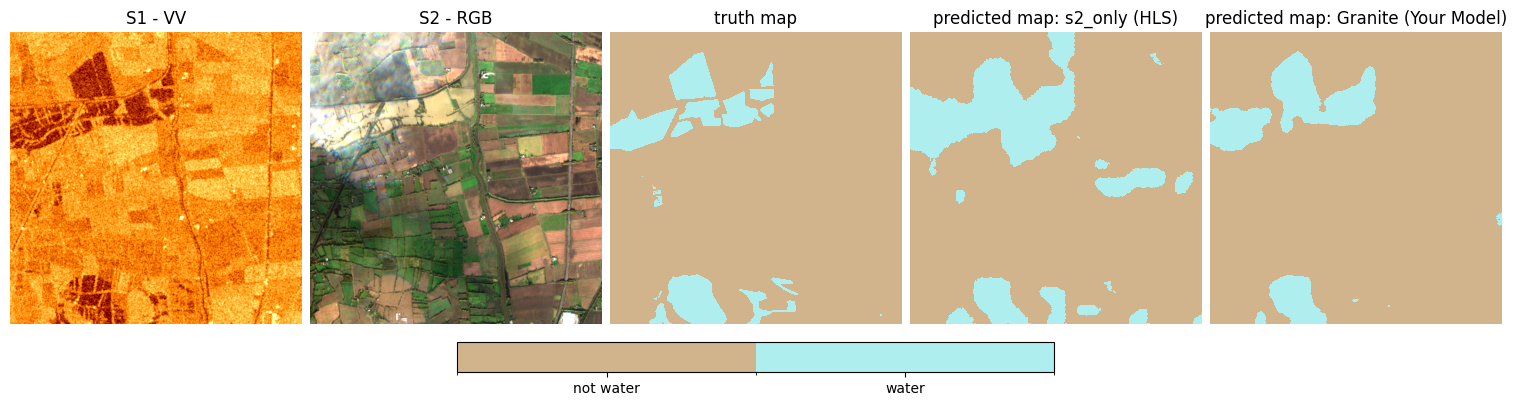

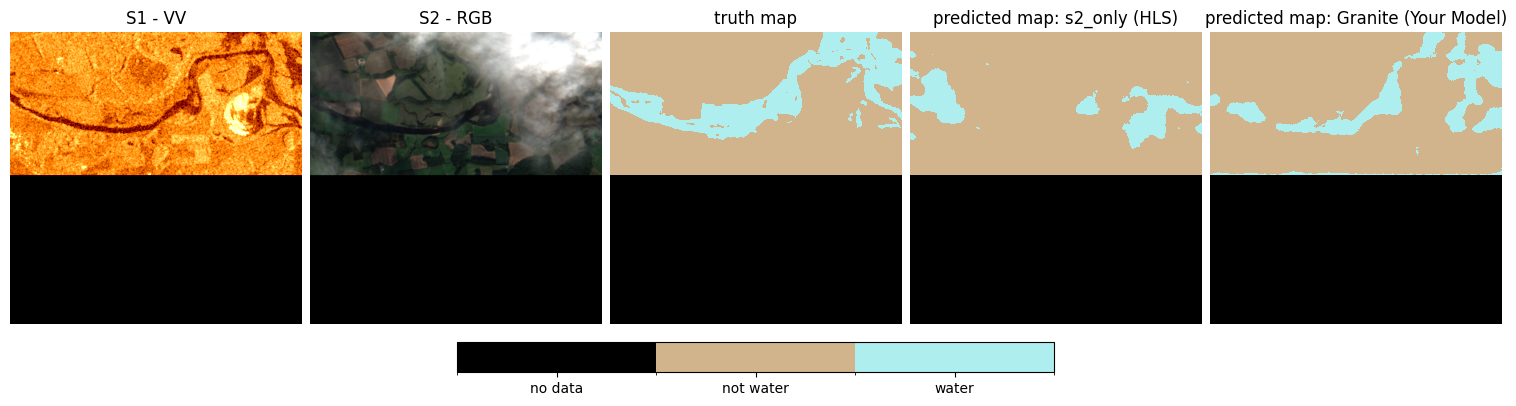

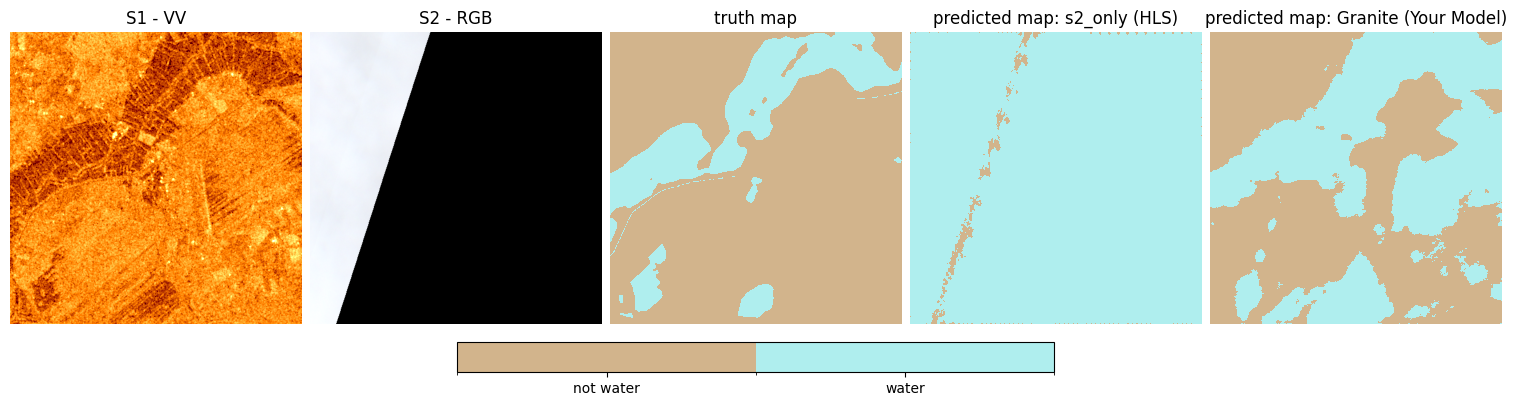

In [7]:
# Cell G: Generate Comparison Plots
print("\nRunning Cell G: Generate Comparison Plots...")

if not helpers_imported_cell_f:
    print("Skipping plot generation as helper functions are not imported.")
elif not (predictions_dir.exists() and input_images_dir.exists() and truth_labels_dir.exists()):
    print("Skipping plot generation due to missing prediction, input, or label directories.")
else:
    # Example images to plot
    example_images_stems = [
        "EMSR407_AOI_3_2019-11-14_tile_0_2",  # mostly cloud-free
        "EMSR698_AOI_36_2023-10-10_tile_4_1",  # half cloudy
        "EMSR429_AOI_55_2020-02-26_tile_0_2",  # very cloudy
    ]

    # Path for S2-only (HLS) model predictions (from your original script)
    # This requires the 'resources/s2_only_inference' directory and its files to exist.
    inf_dir_HLS = absolute_project_root / "resources" / "s2_only_inference"
    print(f"Looking for HLS predictions in: {inf_dir_HLS}, Exists: {inf_dir_HLS.exists()}")
    if not inf_dir_HLS.exists():
        print(f"WARNING: HLS prediction directory {inf_dir_HLS} not found. HLS plots will be skipped or may error if files are expected.")

    # Collect files
    truth_label_files = sorted(list(truth_labels_dir.rglob("EMSR*test*label.tif")))
    pred_labels_HLS_files = sorted(list(inf_dir_HLS.rglob("EMSR*test*image_pred.tif"))) # HLS predictions
    pred_labels_granite_files = sorted(list(predictions_dir.rglob("EMSR*test*image_pred.tif"))) # model's predictions
    input_image_files = sorted(list(input_images_dir.rglob("EMSR*test*image.tif")))

    # Debug: Check how many files were found
    print(f"Found {len(truth_label_files)} truth labels.")
    print(f"Found {len(pred_labels_HLS_files)} HLS predicted labels.")
    print(f"Found {len(pred_labels_granite_files)} Granite (your model) predicted labels.")
    print(f"Found {len(input_image_files)} input images.")

    # Directory to save plots
    plot_save_dir = absolute_project_root / "plots" / "uki_model_comparison_manual"
    os.makedirs(plot_save_dir, exist_ok=True)
    print(f"Plots will be saved to: {plot_save_dir}")

    # Example: "EMSR407_AOI_3_2019-11-14_tile_0_2_test_image.tif" -> "EMSR407_AOI_3_2019-11-14_tile_0_2"
    search_pattern = "(.*?_test)" # Simpler pattern: captures everything before "_test"
                                   # Original: "(.*?\\d{4}-\\d{2}-\\d{2}.*?tile.*?\\d.*?\\d)"

    # Create dictionaries for easy lookup by stem
    def create_file_dict(file_list, pattern):
        d = {}
        for f_path in file_list:
            match = re.search(pattern, f_path.stem)
            if match:
                stem_key = match.group(1).replace("_test", "") # Get the part before _test
                d[stem_key] = f_path
            else: # Fallback if pattern doesn't match _test, try to get full stem before any known suffix
                stem_key_simple = f_path.stem.replace("_test_image_pred","").replace("_test_label","").replace("_test_image","")
                d[stem_key_simple] = f_path
        return d

    truth_dict = create_file_dict(truth_label_files, search_pattern)
    hls_pred_dict = create_file_dict(pred_labels_HLS_files, search_pattern)
    granite_pred_dict = create_file_dict(pred_labels_granite_files, search_pattern)
    input_dict = create_file_dict(input_image_files, search_pattern)
    
    for stem in example_images_stems:
        input_f = input_dict.get(stem)
        truth_f = truth_dict.get(stem)
        hls_f = hls_pred_dict.get(stem)
        granite_f = granite_pred_dict.get(stem)

        if input_f and truth_f and granite_f:
            print(f"Generating plot for: {stem}")
            if not hls_f:
                print(f"  Warning: HLS prediction for {stem} not found. Plotting without it or it might cause an error in compare_images_label_pred if it strictly requires 4 images.")
            if hls_f: # Only plot if HLS is also available for a full comparison
                 compare_images_label_pred(
                    input_f,
                    truth_f,
                    hls_f,    # HLS prediction
                    granite_f,# model's prediction
                    "s2_only (HLS)",
                    "Granite (Your Model)",
                    vv_band,
                    rgb_bands,
                    plot_save_dir,
                 )
            else:
                print(f"  Skipping plot for {stem} as HLS prediction is missing and full comparison plot needs it.")
        else:
            print(f"Skipping plot for {stem} due to missing one or more required files:")
            if not input_f: print(f"  Missing input: {stem}")
            if not truth_f: print(f"  Missing truth label: {stem}")
            if not granite_f: print(f"  Missing Granite prediction: {stem}")

In [8]:
# Cell H: Calculate and Display Metrics
print("\nRunning Cell H: Calculate and Display Metrics...")

if not helpers_imported_cell_f:
    print("Skipping metrics calculation as helper functions are not imported.")
elif not (predictions_dir.exists() and truth_labels_dir.exists()):
    print("Skipping metrics calculation due to missing prediction or label directories.")
else:
    metric_dict = defaultdict(float)

    # --- Evaluation for Granite Model ---
    # 'predictions_dir' points to model's output
    # 'truth_labels_dir' points to the ground truth
    granite_pred_files, granite_truth_files = gather_truth_and_pred(predictions_dir, truth_labels_dir, "test")

    if granite_pred_files and granite_truth_files:
        print(f"Found {len(granite_pred_files)} prediction files and {len(granite_truth_files)} truth files for Granite model.")
        metric_dict[f"Your Granite Model | all images ({len(granite_truth_files)} images)"] = calc_metrics(
            granite_truth_files, granite_pred_files
        )

        # Filter for "good_images"
        good_images_stems = [
            "EMSR407_AOI_3_2019-11-14_tile_0_2",
            "EMSR407_AOI_3_2019-11-14_tile_1_1",
            "EMSR429_AOI_5_2020-03-02_tile_2_1",
            "EMSR429_AOI_5_2020-03-02_tile_3_2",
            "EMSR429_AOI_61_2020-02-26_tile_2_3",
        ]
        
        # Assuming the file stem before "_test" is the key
        granite_truth_files_good = [
            tf for tf in granite_truth_files if tf.stem.split("_test")[0] in good_images_stems
        ]
        granite_pred_files_good = [
            pf for pf in granite_pred_files if pf.stem.split("_test")[0] in good_images_stems
        ]
        
        if granite_truth_files_good and granite_pred_files_good:
             print(f"Found {len(granite_truth_files_good)} good images for Granite model evaluation.")
             metric_dict[f"Your Granite Model | good images ({len(granite_truth_files_good)} images)"] = calc_metrics(
                granite_truth_files_good, granite_pred_files_good
            )
        else:
            print("No 'good' images found for Granite model based on the provided stems, or missing corresponding pred/truth files.")

    else:
        print("No prediction or truth files found for your Granite model in the specified directories.")

    inf_dir_HLS = absolute_project_root / "resources" / "s2_only_inference" # Same as in Cell G
    if inf_dir_HLS.exists():
        hls_pred_files, hls_truth_files = gather_truth_and_pred(inf_dir_HLS, truth_labels_dir, "test")
        if hls_pred_files and hls_truth_files:
            print(f"Found {len(hls_pred_files)} prediction files and {len(hls_truth_files)} truth files for HLS model.")
            metric_dict[f"S2 only model (HLS) | all images ({len(hls_truth_files)} images)"] = calc_metrics(
                hls_truth_files, hls_pred_files
            )
            
            hls_truth_files_good = [
                tf for tf in hls_truth_files if tf.stem.split("_test")[0] in good_images_stems
            ]
            hls_pred_files_good = [
                pf for pf in hls_pred_files if pf.stem.split("_test")[0] in good_images_stems
            ]

            if hls_truth_files_good and hls_pred_files_good:
                print(f"Found {len(hls_truth_files_good)} good images for HLS model evaluation.")
                metric_dict[f"S2 only model (HLS) | good images ({len(hls_truth_files_good)} images)"] = calc_metrics(
                    hls_truth_files_good, hls_pred_files_good
                )
            else:
                print("No 'good' images found for HLS model based on the provided stems, or missing corresponding pred/truth files.")
        else:
            print(f"No prediction or truth files found for HLS model in {inf_dir_HLS} or {truth_labels_dir}.")
    else:
        print(f"HLS prediction directory {inf_dir_HLS} not found. Skipping HLS metrics.")

    # --- Display Metrics Table ---
    if metric_dict:
        metrics_df = pd.DataFrame.from_dict(metric_dict, orient="index").reset_index()
        metrics_df[["model_name_full", "eval_target"]] = metrics_df["index"].str.split("|", expand=True)
        metrics_df.rename(columns={"index": "original_key", "model_name_full": "model"}, inplace=True)
        metrics_df["model"] = metrics_df["model"].str.strip()
        metrics_df["eval_target"] = metrics_df["eval_target"].str.strip()
        
        final_columns = ["model", "eval_target"]
        if "mIoU" in metrics_df.columns: final_columns.append("mIoU")
        if "F1" in metrics_df.columns: final_columns.append("F1")
        
        metrics_df_display = metrics_df[[col for col in final_columns if col in metrics_df.columns]]
        
        print("\nMetrics Table:")
        display(metrics_df_display)
    else:
        print("No metrics were calculated.")


Running Cell H: Calculate and Display Metrics...
Found 9 prediction files and 9 truth files for Granite model.
Found 5 good images for Granite model evaluation.
Found 9 prediction files and 9 truth files for HLS model.
Found 5 good images for HLS model evaluation.

Metrics Table:


,model,eval_target,mIoU,F1
0,Your Granite Model,all images (9 images),0.776315,0.933488
1,Your Granite Model,good images (5 images),0.842762,0.965713
2,S2 only model (HLS),all images (9 images),0.571205,0.820831
3,S2 only model (HLS),good images (5 images),0.725809,0.925691


In [9]:
import os
os.listdir("/kaggle/input/preprocessed/preprocessed")

['PreFlood_t-7_to_t-0_25_17.9_83.3588-0000000000-0000007680_1.pt',
 'PreFlood_t-7_to_t-0_9_27.6131_94.9387-0000007680-0000007680_1.pt',
 'NonFlood_27_23.4991_91.5736-0000000000-0000000000_0.pt',
 'PreFlood_t-7_to_t-0_25_17.9_83.3588-0000007680-0000007680_1.pt',
 'NonFlood_34_27.0678_94.2459-0000007680-0000007680_0.pt',
 'NonFlood_30_11.4575_76.0842-0000000000-0000007680_0.pt',
 'PreFlood_t-7_to_t-0_24_31.3414_76.6285-0000007680-0000007680_1.pt',
 'NonFlood_27_23.4991_91.5736-0000007680-0000000000_0.pt',
 'PreFlood_t-7_to_t-0_19_12.5238_75.6883-0000007680-0000000000_1.pt',
 'NonFlood_12_28.1657_79.076-0000007680-0000007680_0.pt',
 'PreFlood_t-7_to_t-0_23_26.0513_94.7655-0000000000-0000000000_1.pt',
 'NonFlood_32_25.3928_74.3521-0000007680-0000000000_0.pt',
 'PreFlood_t-7_to_t-0_18_19.5656_74.5501-0000000000-0000007680_1.pt',
 'NonFlood_41_17.654_80.34-0000007680-0000007680_0.pt',
 'NonFlood_21_27.2914_94.1222-0000007680-0000007680_0.pt',
 'NonFlood_23_26.0513_94.7655-0000000000-00000076

In [33]:
# Cell H1: Imports and Initial Setup
import os
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm # For progress bars

# --- Configuration ---
# Paths to your Granite model checkpoint and config (from your successful setup)
# These should be the absolute paths you used in Cell E that worked.
GRANITE_MODEL_CHECKPOINT_PATH = "/kaggle/working/geospatial/uki-flooddetection/data/checkpoints/granite_geospatial_uki_flood_detection_v1.ckpt" # e.g., "/kaggle/working/geospatial/uki-flooddetection/data/checkpoints/granite_geospatial_uki_flood_detection_v1.ckpt"
GRANITE_MODEL_CONFIG_PATH = "/kaggle/working/geospatial/uki-flooddetection/configs/config_granite_geospatial_uki_flood_detection_v1.yaml"   # e.g., "/kaggle/working/geospatial/uki-flooddetection/configs/config_granite_geospatial_uki_flood_detection_v1.yaml"

# Path to your uploaded preprocessed data on Kaggle
# Replace 'your-dataset-name' with the actual name of your Kaggle dataset
# and adjust the rest of the path based on how your zip file was structured.
KAGGLE_PREPROCESSED_DATA_ROOT = Path("/kaggle/input/preprocessed/preprocessed/") # ADJUST THIS PATH

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Verify paths
if not Path(GRANITE_MODEL_CHECKPOINT_PATH).exists():
    print(f"ERROR: Granite Checkpoint not found at {GRANITE_MODEL_CHECKPOINT_PATH}")
if not Path(GRANITE_MODEL_CONFIG_PATH).exists():
    print(f"ERROR: Granite Config not found at {GRANITE_MODEL_CONFIG_PATH}")
if not KAGGLE_PREPROCESSED_DATA_ROOT.exists():
    print(f"ERROR: Preprocessed data root not found at {KAGGLE_PREPROCESSED_DATA_ROOT}")
    print("Please ensure you've uploaded your data to Kaggle and set the correct path.")

Using device: cpu


In [34]:
# Cell H2 (Revised V3 - Focused Encoder Weight Loading)
import os
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import yaml
import segmentation_models_pytorch as smp

# --- Global variables for hook ---
hooked_features = None
def hook_fn(module, input, output):
    global hooked_features
    if isinstance(output, list):
        hooked_features = output[-1]
    else:
        hooked_features = output

# --- Configuration (ensure these are defined from Cell H1) ---
# GRANITE_MODEL_CHECKPOINT_PATH, GRANITE_MODEL_CONFIG_PATH, DEVICE should be in scope from Cell H1

feature_extractor_function = None
features_out_dim = None
active_hook_handle = None

print("Attempting workaround V3: Manually constructing model and focusing on encoder weights...")

if not (Path(GRANITE_MODEL_CHECKPOINT_PATH).exists() and Path(GRANITE_MODEL_CONFIG_PATH).exists()):
    print("ERROR: Granite Checkpoint or Config path not found. Cannot proceed.")
else:
    try:
        print(f"Loading YAML config from: {GRANITE_MODEL_CONFIG_PATH}")
        with open(GRANITE_MODEL_CONFIG_PATH, 'r') as f:
            config = yaml.safe_load(f)

        model_config = config.get('model', {}).get('init_args', {})
        smp_model_name = model_config.get('model', 'unet')
        smp_encoder_name_from_config = model_config.get('backbone', 'tu-resnest50d')
        
        smp_encoder_name_for_smp = smp_encoder_name_from_config
        if smp_encoder_name_from_config.startswith('tu-'):
            smp_encoder_name_for_smp = f"timm-{smp_encoder_name_from_config[3:]}"
        
        in_channels = model_config.get('in_channels', 13)
        num_classes = model_config.get('num_classes', 2)

        print(f"Config: SMP Model='{smp_model_name}', Encoder (for SMP)='{smp_encoder_name_for_smp}', InChannels={in_channels}")

        print(f"Instantiating SMP model: {smp_model_name.capitalize()} with encoder {smp_encoder_name_for_smp}")
        smp_model_class = getattr(smp, smp_model_name.capitalize())
        
        smp_model = smp_model_class(
            encoder_name=smp_encoder_name_for_smp,
            encoder_weights=None, # Critical: We are loading custom fine-tuned weights
            in_channels=in_channels,
            classes=num_classes 
        )
        smp_model.to(DEVICE)
        # Don't set smp_model.eval() yet, load weights first.
        print("SMP model instantiated.")

        # --- Load weights specifically into the encoder's TIMM model ---
        print(f"Loading checkpoint state_dict from: {GRANITE_MODEL_CHECKPOINT_PATH}")
        checkpoint = torch.load(GRANITE_MODEL_CHECKPOINT_PATH, map_location=DEVICE)
        lightning_state_dict = checkpoint['state_dict']

        # Target the actual TIMM backbone model within the SMP encoder
        timm_backbone_model = smp_model.encoder.model # This is the nn.Module we want to load weights into

        # Prepare a state dict for the TIMM backbone
        timm_backbone_state_dict = {}
        # This is the prefix we identified from the "Unexpected keys" that seemed to hold the TIMM layers
        prefix_in_ckpt_for_timm_layers = "model.encoder.model._timm_module." 
        
        found_timm_weights = False
        print(f"Looking for keys in checkpoint starting with: '{prefix_in_ckpt_for_timm_layers}'")
        for key, value in lightning_state_dict.items():
            if key.startswith(prefix_in_ckpt_for_timm_layers):
                # Strip this long prefix to get the plain TIMM layer name
                timm_layer_name = key[len(prefix_in_ckpt_for_timm_layers):]
                timm_backbone_state_dict[timm_layer_name] = value
                found_timm_weights = True
        
        if found_timm_weights:
            print(f"Found {len(timm_backbone_state_dict)} keys presumably for the TIMM backbone.")
            print(f"Attempting to load these into smp_model.encoder.model ({type(timm_backbone_model).__name__})...")
            try:
                # Load these keys directly into the timm_backbone_model
                missing_timm_keys, unexpected_timm_keys = timm_backbone_model.load_state_dict(timm_backbone_state_dict, strict=False)
                print("TIMM backbone weights loaded.")
                if missing_timm_keys: print(f"  Missing keys in TIMM backbone: {missing_timm_keys}") # Should ideally be few or none
                if unexpected_timm_keys: print(f"  Unexpected keys for TIMM backbone: {unexpected_timm_keys}") # Should ideally be few or none
                if not missing_timm_keys: print("  Looks like a good match for TIMM backbone weights!")
            except RuntimeError as e:
                print(f"ERROR loading state_dict into TIMM backbone: {e}")
                raise e
        else:
            print(f"ERROR: No TIMM backbone weights found in checkpoint with prefix '{prefix_in_ckpt_for_timm_layers}'.")
            print("The features extracted will likely be from a randomly initialized or default pretrained (not fine-tuned) encoder.")

        smp_model.eval() # Now set the whole SMP model to eval mode
        print("SMP model set to evaluation mode.")

        # --- Set up Hook for Feature Extraction on the (hopefully) correctly weighted encoder ---
        feature_extractor_base_model = smp_model.encoder # Hook the SMP encoder wrapper
        
        active_hook_handle = feature_extractor_base_model.register_forward_hook(hook_fn)
        
        dummy_input_channels = in_channels
        print(f"Probing feature extractor with dummy input ({dummy_input_channels} channels).")
        dummy_input = torch.randn(1, dummy_input_channels, 128, 128).to(DEVICE)
        with torch.no_grad():
            _ = feature_extractor_base_model(dummy_input) 

        if hooked_features is not None:
            pooled_features = nn.functional.adaptive_avg_pool2d(hooked_features, (1, 1))
            features_out_dim = pooled_features.shape[1]
            print(f"Raw hooked features map shape (Batch, Channels, H, W): {hooked_features.shape}")
            print(f"Pooled features shape (Batch, Channels, 1, 1): {pooled_features.shape}")
            print(f"Determined output feature vector dimension: {features_out_dim}")

            def get_features(image_tensor_chw):
                if image_tensor_chw.ndim == 3: image_batch = image_tensor_chw.unsqueeze(0).to(DEVICE)
                elif image_tensor_chw.ndim == 4: image_batch = image_tensor_chw.to(DEVICE)
                else: print(f"ERROR: Input tensor has unexpected ndim: {image_tensor_chw.ndim}"); return None
                if image_batch.shape[1] != dummy_input_channels: print(f"WARNING: Input tensor has {image_batch.shape[1]} channels, model expects {dummy_input_channels}.")
                
                global hooked_features
                hooked_features = None 
                with torch.no_grad(): _ = feature_extractor_base_model(image_batch)
                if hooked_features is not None:
                    pooled = nn.functional.adaptive_avg_pool2d(hooked_features, (1, 1))
                    return pooled.squeeze() 
                else: print("Error: Hook did not capture features on this call."); return None
            
            feature_extractor_function = get_features
            print("Feature extractor function is ready.")
        else:
            print("ERROR: Could not capture features with the hook. Hooked_features is None.")
            if active_hook_handle: active_hook_handle.remove()
            
    except ImportError as e_smp:
        print(f"ERROR: Could not import 'segmentation_models_pytorch'. Is it installed? Error: {e_smp}")
    except AttributeError as e_attr:
        print(f"ERROR: Could not find SMP model (e.g., '{smp_model_name.capitalize()}') in 'segmentation_models_pytorch'. Error: {e_attr}")
    except Exception as e:
        print(f"An error occurred during workaround model setup: {e}")
        import traceback
        traceback.print_exc()
        if active_hook_handle: active_hook_handle.remove()

if not feature_extractor_function:
    print("\nCRITICAL: Feature extractor function could NOT be set up.")

Attempting workaround V3: Manually constructing model and focusing on encoder weights...
Loading YAML config from: /kaggle/working/geospatial/uki-flooddetection/configs/config_granite_geospatial_uki_flood_detection_v1.yaml
Config: SMP Model='unet', Encoder (for SMP)='timm-resnest50d', InChannels=13
Instantiating SMP model: Unet with encoder timm-resnest50d
SMP model instantiated.
Loading checkpoint state_dict from: /kaggle/working/geospatial/uki-flooddetection/data/checkpoints/granite_geospatial_uki_flood_detection_v1.ckpt
Looking for keys in checkpoint starting with: 'model.encoder.model._timm_module.'
ERROR: No TIMM backbone weights found in checkpoint with prefix 'model.encoder.model._timm_module.'.
The features extracted will likely be from a randomly initialized or default pretrained (not fine-tuned) encoder.
SMP model set to evaluation mode.
Probing feature extractor with dummy input (13 channels).
Raw hooked features map shape (Batch, Channels, H, W): torch.Size([1, 2048, 4, 4])

In [35]:
# Cell H3 (Revised for Channel Selection and Flat Directory)
import os
import torch
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import re

# Ensure KAGGLE_PREPROCESSED_DATA_ROOT, DEVICE, feature_extractor_function, 
# and dummy_input_channels (from Cell H2, should be 13) are in scope.

all_sequences_features = []
all_sequences_labels = []

# --- USER ACTION REQUIRED: Define which 13 channels to keep ---
# You have 19 channels. The model expects 'dummy_input_channels' (likely 13).
# List the 0-based indices of the 13 channels you want to select from your 19 channels.
# For example, if you want the first 13 channels:
# channel_indices_to_keep = list(range(13)) 
# Or if they are specific known bands, e.g., [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18]
# **YOU MUST DEFINE THIS BASED ON YOUR DATA AND THE MODEL'S EXPECTATIONS**
channel_indices_to_keep = list(range(13)) # <<< --- !!! Placeholder: Takes the first 13 channels. ADJUST THIS!
if 'dummy_input_channels' in locals() and len(channel_indices_to_keep) != dummy_input_channels:
    print(f"ERROR: 'channel_indices_to_keep' has {len(channel_indices_to_keep)} indices, but model expects {dummy_input_channels} channels. Please correct.")
    # Stop execution by raising an error or exit() if in a script
    raise ValueError(f"Channel selection mismatch: selected {len(channel_indices_to_keep)}, model expects {dummy_input_channels}")
else:
    print(f"Will select {len(channel_indices_to_keep)} channels using indices: {channel_indices_to_keep}")
# --- END USER ACTION ---


if 'feature_extractor_function' not in locals() or feature_extractor_function is None:
    print("ERROR: 'feature_extractor_function' not initialized from Cell H2. Cannot proceed.")
elif 'KAGGLE_PREPROCESSED_DATA_ROOT' not in locals() or not KAGGLE_PREPROCESSED_DATA_ROOT.exists():
    print(f"ERROR: Data root directory KAGGLE_PREPROCESSED_DATA_ROOT not found or not defined from Cell H1.")
else:
    print(f"Scanning data root: {KAGGLE_PREPROCESSED_DATA_ROOT} for .pt files...")
    
    event_files = {}
    pt_files_found = list(KAGGLE_PREPROCESSED_DATA_ROOT.glob("*.pt"))
    print(f"Found {len(pt_files_found)} total .pt files in the directory.")

    for pt_file in pt_files_found:
        filename_stem = pt_file.stem
        label = -1
        core_identifier_string = ""

        if filename_stem.startswith("NonFlood_") and filename_stem.endswith("_0"):
            label = 0
            core_identifier_string = filename_stem[len("NonFlood_"):-2]
        elif filename_stem.startswith("PreFlood_") and filename_stem.endswith("_1"):
            label = 1
            core_identifier_string = filename_stem[len("PreFlood_"):-2]
        else:
            continue

        match = re.match(r'(.+)-(\d{10})-(\d{10})$', core_identifier_string)
        event_identifier_part = match.group(1) if match else core_identifier_string
        sort_key = core_identifier_string
        full_event_id_key = f"{pt_file.name.split('_')[0]}_{event_identifier_part}"

        if full_event_id_key not in event_files: event_files[full_event_id_key] = []
        event_files[full_event_id_key].append({'path': pt_file, 'sort_key': sort_key, 'label': label})

    print(f"Grouped into {len(event_files)} unique event sequences.")
    
    processed_sequences_count = 0
    for event_id_key, file_infos_list in tqdm(event_files.items(), desc="Processing event sequences"):
        sorted_file_infos = sorted(file_infos_list, key=lambda x: x['sort_key'])
        current_sequence_features = []
        current_sequence_label = sorted_file_infos[0]['label']
        valid_sequence = True

        if not (3 <= len(sorted_file_infos) <= 5): continue

        for i, file_info in enumerate(sorted_file_infos):
            pt_filepath = file_info['path']
            if file_info['label'] != current_sequence_label: valid_sequence = False; break
            
            try:
                img_tensor_19channels = torch.load(pt_filepath, map_location=DEVICE)

                # --- CHANNEL SELECTION ---
                if img_tensor_19channels.shape[0] == 19:
                    img_tensor = img_tensor_19channels[channel_indices_to_keep, :, :]
                elif img_tensor_19channels.shape[0] == dummy_input_channels: # Already correct number of channels
                    img_tensor = img_tensor_19channels
                else:
                    print(f"  Skipping {pt_filepath.name}: Expected 19 or {dummy_input_channels} channels, got {img_tensor_19channels.shape[0]}.")
                    valid_sequence = False; break
                # --- END CHANNEL SELECTION ---

                if i == 0 and processed_sequences_count < 1: # Print for first image of first successfully grouped event
                     print(f"  Data stats for {pt_filepath.name} (after channel selection to {img_tensor.shape[0]} ch): min={img_tensor.min().item():.4f}, max={img_tensor.max().item():.4f}, dtype={img_tensor.dtype}")

                if img_tensor.dtype != torch.float32: img_tensor = img_tensor.float()
                
                # --- NORMALIZATION (Adjust based on your data's true original scale) ---
                max_val = img_tensor.max().item()
                # The data stats you provided (max ~0.4 to 0.9, sometimes 1.02, 1.2) suggest it might already be somewhat normalized or scaled.
                # If your .pt files are already in a [0,1] or similar suitable range after channel selection, 
                # extensive normalization might not be needed, or just a clamp.
                if max_val > 1.05: # If significantly above 1, apply some scaling/clamping
                    print(f"    Scaling/clamping tensor for {pt_filepath.name} (max val: {max_val}).")
                    img_tensor_normalized = torch.clamp(img_tensor / max_val, 0, 1) # Scale by its own max
                else: # Assumes mostly in [0,1] or needs only clamping
                    img_tensor_normalized = torch.clamp(img_tensor, 0, 1) # Ensure it's strictly [0,1]
                # --- END NORMALIZATION ---
                                    
                features = feature_extractor_function(img_tensor_normalized) 
                
                if features is not None:
                    current_sequence_features.append(features.cpu().numpy())
                else: valid_sequence = False; break
            except Exception as e:
                print(f"Error processing file {pt_filepath.name}: {e}")
                valid_sequence = False; break
        
        if valid_sequence and current_sequence_features:
            all_sequences_features.append(np.array(current_sequence_features))
            all_sequences_labels.append(current_sequence_label)
            processed_sequences_count += 1

    print(f"\nProcessed {len(all_sequences_features)} valid sequences in total.")
    
    features_save_path = Path("/kaggle/working/extracted_lstm_features.npy")
    labels_save_path = Path("/kaggle/working/extracted_lstm_labels.npy")
    
    if all_sequences_features:
        np.save(features_save_path, np.array(all_sequences_features, dtype=object)) 
        np.save(labels_save_path, np.array(all_sequences_labels))
        print(f"Saved features to {features_save_path}")
        print(f"Saved labels to {labels_save_path}")
        print(f"Number of feature sequences: {len(all_sequences_features)}")
        # features_out_dim should be available from Cell H2
        expected_feature_dim = locals().get('features_out_dim', 'UNKNOWN_FROM_H2')
        print(f"  Shape of first feature sequence: {all_sequences_features[0].shape} (should be Seq_Len, {expected_feature_dim})")
        print(f"Number of labels: {len(all_sequences_labels)}")
    else:
        print("No features were extracted. Nothing saved.")

Will select 13 channels using indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Scanning data root: /kaggle/input/preprocessed/preprocessed for .pt files...
Found 150 total .pt files in the directory.
Grouped into 47 unique event sequences.


Processing event sequences:   0%|          | 0/47 [00:00<?, ?it/s]

  Data stats for PreFlood_t-7_to_t-0_25_17.9_83.3588-0000000000-0000000000_1.pt (after channel selection to 13 ch): min=0.0000, max=0.4721, dtype=torch.float32
    Scaling/clamping tensor for NonFlood_39_27.464_95.607-0000007680-0000000000_0.pt (max val: 1.0633161067962646).
    Scaling/clamping tensor for NonFlood_39_27.464_95.607-0000007680-0000007680_0.pt (max val: 1.1812117099761963).
    Scaling/clamping tensor for NonFlood_16_33.3752_75.1439-0000000000-0000007680_0.pt (max val: 1.2000739574432373).

Processed 37 valid sequences in total.
Saved features to /kaggle/working/extracted_lstm_features.npy
Saved labels to /kaggle/working/extracted_lstm_labels.npy
Number of feature sequences: 37
  Shape of first feature sequence: (4, 2048) (should be Seq_Len, 2048)
Number of labels: 37


In [36]:
# Cell H4: Load Extracted Features and Labels
import numpy as np
import torch
from pathlib import Path

print("Running Cell H4: Load Extracted Features and Labels...")

features_save_path = Path("/kaggle/working/extracted_lstm_features.npy")
labels_save_path = Path("/kaggle/working/extracted_lstm_labels.npy")

if features_save_path.exists() and labels_save_path.exists():
    # Load as object array first, as sequences can have different lengths
    all_sequences_features_loaded = np.load(features_save_path, allow_pickle=True)
    all_sequences_labels_loaded = np.load(labels_save_path, allow_pickle=True)

    print(f"Loaded {len(all_sequences_features_loaded)} feature sequences.")
    print(f"Loaded {len(all_sequences_labels_loaded)} labels.")

    if len(all_sequences_features_loaded) > 0:
        print(f"  Shape of first loaded feature sequence: {all_sequences_features_loaded[0].shape}")
        # Assuming features_out_dim was set in Cell H2 and is in scope
        if 'features_out_dim' in locals():
            print(f"  Expected feature dimension: {features_out_dim}")
        else: # Fallback if features_out_dim isn't in scope from H2 (should be 2048)
            features_out_dim = all_sequences_features_loaded[0].shape[1]
            print(f"  Inferred feature dimension: {features_out_dim}")

    # Convert labels to a tensor
    all_sequences_labels_tensor = torch.tensor(all_sequences_labels_loaded, dtype=torch.float32) # For BCEWithLogitsLoss
    
    # Feature sequences are already numpy arrays, will be converted to tensors in Dataset/DataLoader
else:
    print("ERROR: Saved features or labels .npy files not found in /kaggle/working/")
    print("Please ensure Cell H3 ran successfully and saved the files.")
    # To prevent errors in subsequent cells if files are missing:
    all_sequences_features_loaded = [] 
    all_sequences_labels_tensor = torch.tensor([])
    features_out_dim = None # Needs to be set

Running Cell H4: Load Extracted Features and Labels...
Loaded 37 feature sequences.
Loaded 37 labels.
  Shape of first loaded feature sequence: (4, 2048)
  Expected feature dimension: 2048


In [37]:
# Cell H5: Prepare PyTorch Datasets and DataLoaders
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

print("\nRunning Cell H5: Prepare PyTorch Datasets and DataLoaders...")

# Ensure DEVICE is in scope from Cell H1
if 'DEVICE' not in locals():
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Re-defined DEVICE: {DEVICE}")


if len(all_sequences_features_loaded) > 0 and features_out_dim is not None:
    # Split data into training and validation sets
    # Given only 37 sequences, the validation set will be small. Consider a 80/20 or 70/30 split.
    # For very small datasets, sometimes k-fold cross-validation is preferred, but let's do a simple split for now.
    X_train_seq, X_val_seq, y_train, y_val = train_test_split(
        all_sequences_features_loaded, 
        all_sequences_labels_tensor.numpy(), # Convert tensor to numpy for sklearn split
        test_size=0.2, # e.g., 20% for validation
        random_state=42, 
        stratify=all_sequences_labels_tensor.numpy() # Stratify by labels if possible
    )

    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    print(f"Training sequences: {len(X_train_seq)}, Validation sequences: {len(X_val_seq)}")

    class SequenceDataset(Dataset):
        def __init__(self, sequences, labels):
            self.sequences = sequences
            self.labels = labels

        def __len__(self):
            return len(self.sequences)

        def __getitem__(self, idx):
            # Sequence is already a numpy array of shape (seq_len, feature_dim)
            # Convert to tensor here
            sequence_tensor = torch.tensor(self.sequences[idx], dtype=torch.float32)
            label_tensor = self.labels[idx].unsqueeze(0) # Ensure label is (1,) for BCEWithLogitsLoss
            return sequence_tensor, label_tensor

    train_dataset = SequenceDataset(X_train_seq, y_train_tensor)
    val_dataset = SequenceDataset(X_val_seq, y_val_tensor)

    def collate_fn_pad(batch):
        # batch is a list of tuples (sequence_tensor, label_tensor)
        sequences, labels = zip(*batch)
        
        # Get lengths of each sequence
        lengths = torch.tensor([len(seq) for seq in sequences])
        
        # Pad sequences (batch_first=True means output shape is B x T x F)
        padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
        
        # Stack labels (they are already shaped [1,])
        labels_stacked = torch.stack(labels, dim=0)
        
        return padded_sequences, labels_stacked, lengths

    # DataLoaders
    BATCH_SIZE = 4 # Keep batch size small for a small dataset
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_pad)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pad)

    print("Datasets and DataLoaders created.")
    # Example batch
    try:
        example_batch_sequences, example_batch_labels, example_batch_lengths = next(iter(train_loader))
        print(f"  Example padded sequences batch shape: {example_batch_sequences.shape}") # (Batch, Max_Seq_Len, Feature_Dim)
        print(f"  Example labels batch shape: {example_batch_labels.shape}")           # (Batch, 1)
        print(f"  Example lengths batch: {example_batch_lengths}")
    except StopIteration:
        print("  Could not get example batch from train_loader (dataset might be too small or empty).")

else:
    print("Skipping Dataset/DataLoader creation as no features were loaded or feature_dim is unknown.")


Running Cell H5: Prepare PyTorch Datasets and DataLoaders...
Training sequences: 29, Validation sequences: 8
Datasets and DataLoaders created.
  Example padded sequences batch shape: torch.Size([4, 4, 2048])
  Example labels batch shape: torch.Size([4, 1])
  Example lengths batch: tensor([4, 3, 4, 4])


In [38]:
# Cell H6: Define the LSTM Model
import torch.nn as nn

print("\nRunning Cell H6: Define the LSTM Model...")

class FloodLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, output_dim=1, dropout_prob=0.2):
        super(FloodLSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        # batch_first=True makes input/output tensors (batch, seq, feature)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0) 
                            # Dropout is applied between LSTM layers if num_layers > 1
        
        # Fully connected layer to map LSTM output to class scores
        self.fc = nn.Linear(hidden_dim, output_dim)
        # No sigmoid here if using BCEWithLogitsLoss

    def forward(self, x, lengths=None):
        # x shape: (batch, seq_len, feature_dim)
        # lengths: tensor of original sequence lengths (optional, for pack_padded_sequence)

        # Initialize hidden state and cell state with zeros
        # h0 shape: (num_layers, batch, hidden_dim)
        # c0 shape: (num_layers, batch, hidden_dim)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # We can use pack_padded_sequence if original lengths are provided for efficiency,
        # but for small variations and simplicity, LSTM can handle padded sequences directly.
        # If using packing:
        # if lengths is not None:
        #    x = torch.nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # If using packing:
        # if lengths is not None:
        #    lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # We want the output from the last time step of the LSTM for each sequence.
        # If sequences are padded, lstm_out is (batch, seq_len, hidden_dim).
        # We need to get the output corresponding to the actual last time step for each sequence.
        # A common way is to take the last hidden state `hn` of the last layer.
        # hn shape is (num_layers, batch, hidden_dim). hn[-1] is (batch, hidden_dim)
        last_hidden_state = hn[-1] # Output of the last LSTM layer from the last time step (effectively)

        # Alternatively, if not using packing and relying on padding:
        # Gather the outputs from the last *actual* time step of each sequence
        # This is more robust if padding is present and you don't use pack_padded_sequence
        # actual_lengths_indices = (lengths - 1).view(-1, 1).expand(-1, lstm_out.size(2))
        # actual_lengths_indices = actual_lengths_indices.unsqueeze(1)
        # last_outputs = lstm_out.gather(1, actual_lengths_indices).squeeze(1)
        # For simplicity, using hn[-1] is common when not explicitly packing/unpacking and if the task allows.

        out = self.fc(last_hidden_state) # Shape: (batch, output_dim) which is (batch, 1)
        return out

if features_out_dim is not None:
    # Hyperparameters for LSTM
    LSTM_INPUT_DIM = features_out_dim # Should be 2048 from your feature extractor
    LSTM_HIDDEN_DIM = 128  # You can tune this
    LSTM_NUM_LAYERS = 1    # Start simple
    LSTM_OUTPUT_DIM = 1    # For binary classification (single logit)
    LSTM_DROPOUT = 0.3     # Dropout for regularization

    # Instantiate the model
    lstm_model = FloodLSTMClassifier(LSTM_INPUT_DIM, LSTM_HIDDEN_DIM, LSTM_NUM_LAYERS, LSTM_OUTPUT_DIM, LSTM_DROPOUT)
    lstm_model.to(DEVICE)
    print("LSTM model defined and instantiated:")
    print(lstm_model)
else:
    print("Skipping LSTM model definition as features_out_dim is unknown.")


Running Cell H6: Define the LSTM Model...
LSTM model defined and instantiated:
FloodLSTMClassifier(
  (lstm): LSTM(2048, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [39]:
# Cell H7: Training Setup (Loss, Optimizer)
import torch.optim as optim

print("\nRunning Cell H7: Training Setup...")

if 'lstm_model' in locals():
    # Loss Function
    # BCEWithLogitsLoss is suitable for binary classification with a single logit output.
    # It combines a Sigmoid layer and the BCELoss in one single class for better numerical stability.
    criterion = nn.BCEWithLogitsLoss()

    # Optimizer
    # Adam is a good general-purpose optimizer.
    optimizer = optim.Adam(lstm_model.parameters(), lr=0.001) # You can tune the learning rate

    # (Optional) Learning rate scheduler
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    print("Loss function and optimizer defined.")
else:
    print("Skipping training setup as LSTM model is not defined.")


Running Cell H7: Training Setup...
Loss function and optimizer defined.


In [41]:
# Cell H8: LSTM Training Loop
from tqdm.auto import tqdm # For progress bars

print("\nRunning Cell H8: LSTM Training Loop...")

NUM_EPOCHS = 10 # Given the small dataset, you might train for more epochs but watch for overfitting
# For a dataset of ~30 training samples, even 50 epochs might be a lot.
# Consider fewer, or implement early stopping if you have a stable validation set.

if 'lstm_model' in locals() and 'train_loader' in locals() and 'val_loader' in locals():
    print(f"Starting training for {NUM_EPOCHS} epochs...")
    for epoch in range(NUM_EPOCHS):
        lstm_model.train()  # Set model to training mode
        epoch_train_loss = 0.0
        
        for sequences, labels, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False):
            sequences = sequences.to(DEVICE)
            labels = labels.to(DEVICE)
            # lengths are not explicitly used in this simple LSTM forward pass but can be for packing
            
            optimizer.zero_grad()
            outputs = lstm_model(sequences) # Pass lengths if your model uses packing: lstm_model(sequences, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item() * sequences.size(0) # Weighted by batch size

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        
        # Validation phase
        lstm_model.eval() # Set model to evaluation mode
        epoch_val_loss = 0.0
        correct_val_preds = 0
        total_val_samples = 0
        
        with torch.no_grad():
            for sequences, labels, lengths in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False):
                sequences = sequences.to(DEVICE)
                labels = labels.to(DEVICE)
                
                outputs = lstm_model(sequences) # Pass lengths if your model uses packing
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item() * sequences.size(0)
                
                # Calculate accuracy
                predicted_probs = torch.sigmoid(outputs)
                predicted_labels = (predicted_probs > 0.5).float()
                correct_val_preds += (predicted_labels == labels).sum().item()
                total_val_samples += labels.size(0)
        
        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_accuracy = correct_val_preds / total_val_samples if total_val_samples > 0 else 0.0
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        
        # if 'scheduler' in locals(): scheduler.step() # If using a learning rate scheduler

    print("Training finished.")

else:
    print("Skipping training loop as model, train_loader, or val_loader is not defined.")


Running Cell H8: LSTM Training Loop...
Starting training for 10 epochs...


Epoch 1/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/10 -> Train Loss: 0.5210 | Val Loss: 0.4781 | Val Acc: 0.7500


Epoch 2/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/10 -> Train Loss: 0.5104 | Val Loss: 0.4664 | Val Acc: 0.7500


Epoch 3/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/10 -> Train Loss: 0.5095 | Val Loss: 0.4665 | Val Acc: 0.7500


Epoch 4/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/10 -> Train Loss: 0.5016 | Val Loss: 0.4688 | Val Acc: 0.8750


Epoch 5/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/10 -> Train Loss: 0.4972 | Val Loss: 0.4810 | Val Acc: 0.8750


Epoch 6/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/10 -> Train Loss: 0.4885 | Val Loss: 0.4994 | Val Acc: 1.0000


Epoch 7/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/10 -> Train Loss: 0.4914 | Val Loss: 0.4910 | Val Acc: 0.8750


Epoch 8/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/10 -> Train Loss: 0.4845 | Val Loss: 0.5296 | Val Acc: 0.8750


Epoch 9/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/10 -> Train Loss: 0.4757 | Val Loss: 0.5117 | Val Acc: 0.8750


Epoch 10/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/10 -> Train Loss: 0.4667 | Val Loss: 0.5439 | Val Acc: 0.8750
Training finished.



Running Cell H9: Final Evaluation on Validation Set...

--- Validation Set Metrics ---
Accuracy:  0.8750
Precision: 0.6667
Recall:    1.0000
F1-score:  0.8000

Classification Report:
              precision    recall  f1-score   support

NonFlood (0)       1.00      0.83      0.91         6
   Flood (1)       0.67      1.00      0.80         2

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8


Confusion Matrix:
[[5 1]
 [0 2]]


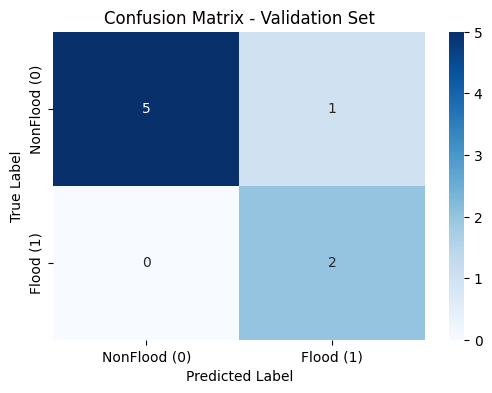

In [42]:
# Cell H9: Final Evaluation on Validation Set
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns # For a prettier confusion matrix
import matplotlib.pyplot as plt # For plotting

print("\nRunning Cell H9: Final Evaluation on Validation Set...")

if 'lstm_model' in locals() and 'val_loader' in locals() and 'DEVICE' in locals():
    lstm_model.eval()  # Set model to evaluation mode
    
    all_val_labels = []
    all_val_predictions = []
    all_val_probs = []

    with torch.no_grad(): # No need to track gradients for evaluation
        for sequences, labels, lengths in val_loader: # val_loader should be defined from Cell H5
            sequences = sequences.to(DEVICE)
            # labels are already tensors from the collate_fn, ensure they are on CPU for sklearn
            # and are 1D for sklearn metrics
            
            outputs = lstm_model(sequences) # Get raw logits
            
            # Convert logits to probabilities
            probs = torch.sigmoid(outputs).cpu() # Move to CPU for numpy conversion
            all_val_probs.extend(probs.numpy()) # Store probabilities

            # Convert probabilities to binary predictions
            predicted_labels = (probs > 0.5).float() # Threshold at 0.5
            all_val_predictions.extend(predicted_labels.numpy())
            
            all_val_labels.extend(labels.cpu().numpy()) # Store true labels

    # Ensure they are flat lists or 1D numpy arrays for sklearn
    all_val_labels_np = np.array(all_val_labels).flatten() # Flatten in case labels were [[0],[1]]
    all_val_predictions_np = np.array(all_val_predictions).flatten()

    if len(all_val_labels_np) > 0 and len(all_val_predictions_np) > 0:
        print("\n--- Validation Set Metrics ---")
        accuracy = accuracy_score(all_val_labels_np, all_val_predictions_np)
        precision = precision_score(all_val_labels_np, all_val_predictions_np, zero_division=0)
        recall = recall_score(all_val_labels_np, all_val_predictions_np, zero_division=0)
        f1 = f1_score(all_val_labels_np, all_val_predictions_np, zero_division=0)

        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-score:  {f1:.4f}")

        print("\nClassification Report:")
        # target_names based on your labels: 0 for NonFlood, 1 for PreFlood/Flood
        print(classification_report(all_val_labels_np, all_val_predictions_np, target_names=['NonFlood (0)', 'Flood (1)'], zero_division=0))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(all_val_labels_np, all_val_predictions_np)
        print(cm)
        
        # Plotting the confusion matrix
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NonFlood (0)', 'Flood (1)'], yticklabels=['NonFlood (0)', 'Flood (1)'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix - Validation Set')
        plt.show()
    else:
        print("No labels or predictions found for the validation set to calculate metrics.")

else:
    print("LSTM model ('lstm_model'), validation loader ('val_loader'), or device ('DEVICE') not found. Cannot evaluate.")